## TLC Data Lab

TLC: Taxi and Limousine commission provides open data for yellow taxis, FHV, shared FHV and green taxis for NYC. Data includes information about each trip containing pick up and drop off times, fare information, number of passengers, miles traveled etc.

### Objectives

- Cleaning the data - filtering out the outliers and trips with unreasonable parameters
- Explore spatial and temporal data distribution of the number of trips, distances etc, fares and the travel speed.
- Practice spatial mapping with geopandas

### Skills

- Data cleaning and sanity checks
- convert non-spatial data to spatial with geopandas
- visualizing data on the maps

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import urllib
import sys
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime

Downloading TLC yellow taxi data January 2019

In [113]:
# read cleaned trips data
data_yellow = pd.read_csv('yellow_trips_19_cleaned.csv')
data_yellow.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


1. Explore spatial distribution of average travel speed and total trip distance by pick up location and visualize on a map

Hint: for average speed a normal color map should be okay while for total distance you might consider quantiles viz.

In [114]:
data_yellow['tpep_pickup_datetime']=data_yellow['tpep_pickup_datetime'].astype('datetime64[m]')
data_yellow['tpep_dropoff_datetime']=data_yellow['tpep_dropoff_datetime'].astype('datetime64[m]')
data_yellow['trip_duration'] = (data_yellow['tpep_dropoff_datetime'] - data_yellow['tpep_pickup_datetime'])
data_yellow['trip_duration'] = data_yellow['trip_duration'].dt.total_seconds()/60
data_yellow['speed'] = data_yellow['trip_distance']/(data_yellow['trip_duration']/60)
data_yellow

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration,speed
0,1,2019-01-01 00:46:00,2019-01-01 00:53:00,1,1.50,1,N,151,239,1,7.0,0.5,0.5,1.65,0.00,0.3,9.95,NaN,7.0,12.857143
1,1,2019-01-01 00:59:00,2019-01-01 01:18:00,1,2.60,1,N,239,246,1,14.0,0.5,0.5,1.00,0.00,0.3,16.30,NaN,19.0,8.210526
2,2,2018-12-21 13:48:00,2018-12-21 13:52:00,3,0.00,1,N,236,236,1,4.5,0.5,0.5,0.00,0.00,0.3,5.80,NaN,4.0,0.000000
3,2,2018-11-28 15:52:00,2018-11-28 15:55:00,5,0.00,1,N,193,193,2,3.5,0.5,0.5,0.00,0.00,0.3,7.55,NaN,3.0,0.000000
4,2,2018-11-28 15:56:00,2018-11-28 15:58:00,5,0.00,2,N,193,193,2,52.0,0.0,0.5,0.00,0.00,0.3,55.55,NaN,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035935,2,2019-01-05 20:10:00,2019-01-05 20:22:00,1,5.90,1,N,138,74,1,17.5,0.5,0.5,4.91,5.76,0.3,29.47,NaN,12.0,29.500000
1035936,2,2019-01-05 20:45:00,2019-01-05 21:12:00,6,15.35,1,N,132,112,1,41.5,0.5,0.5,5.00,0.00,0.3,47.80,NaN,27.0,34.111111
1035937,2,2019-01-05 20:42:00,2019-01-05 21:10:00,1,16.34,2,N,10,236,1,52.0,0.0,0.5,14.64,5.76,0.3,73.20,NaN,28.0,35.014286
1035938,1,2019-01-05 20:02:00,2019-01-05 20:09:00,1,3.30,1,N,262,137,2,11.0,0.5,0.5,0.00,0.00,0.3,12.30,NaN,7.0,28.285714


<AxesSubplot:>

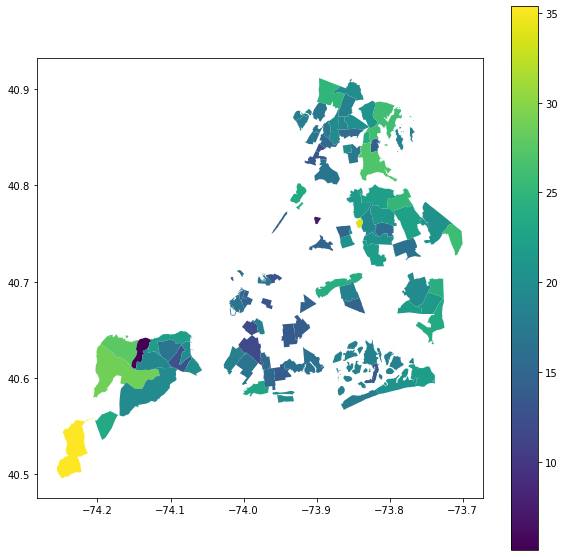

In [118]:
data_yellow = data_yellow[(data_yellow.PULocationID.isin(taxi.location_i)) & (data_yellow.DOLocationID.isin(taxi.location_i))]
trip_speed=data_yellow[['PULocationID','speed']].groupby(by=['PULocationID'],as_index=False).mean()
trip_speed=trip_speed.dropna()

speed_visiz=taxi.merge(trip_speed, left_on='location_i', right_on='PULocationID')
speed_visiz.plot(figsize=(10,10), column='speed', legend=True)

<AxesSubplot:>

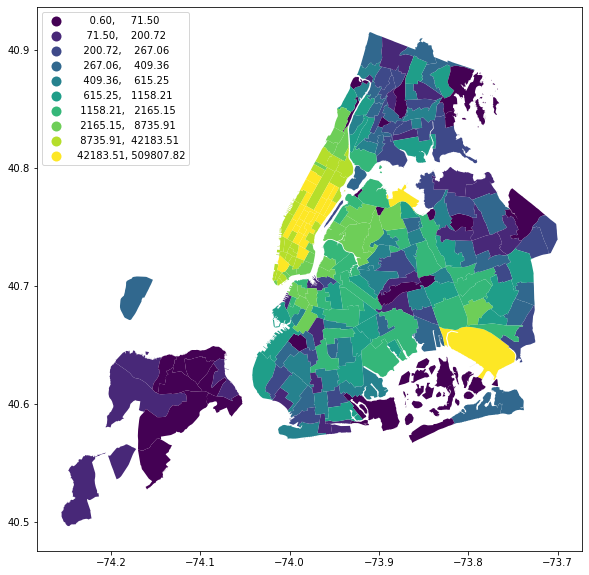

In [123]:
trip_distance=data_yellow[['PULocationID','trip_distance']].groupby(by=['PULocationID'],as_index=False).sum()
distance_visiz=taxi.merge(trip_distance,left_on='location_i', right_on='PULocationID')
fig, ax = plt.subplots(1, figsize=(10,10))

distance_visiz.plot(ax=ax, column='trip_distance', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})

2. Plot travel density by drop off location

Use area normalization, quantile visualization as before but this time aggregte activity by drop off taxi zone

<AxesSubplot:>

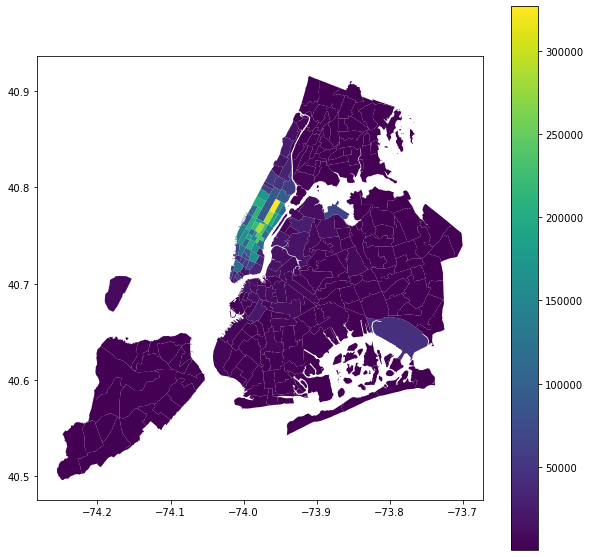

In [126]:
trips_drop = data.groupby(by='DOLocationID', as_index=False).count()[['PULocationID', 'DOLocationID']]
trips_drop.rename(columns={'PULocationID':'N_trips'}, inplace=True)

trips_drop = taxi.merge(trips_drop, left_on='location_i', right_on='DOLocationID')

trips_drop.plot(figsize=(10,10), column='N_trips', legend=True)

<AxesSubplot:>

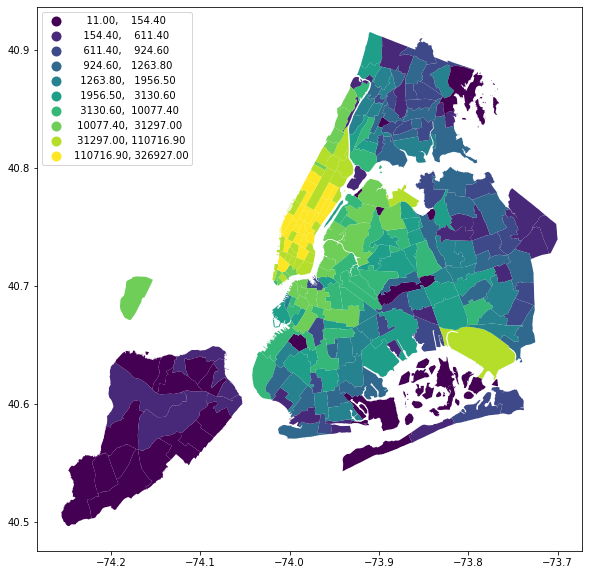

In [124]:
fig, ax = plt.subplots(1, figsize=(10,10))

trips_drop.plot(ax=ax, column='N_trips', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})


3. Explore total number of trips, average speed and total distance by day of the week and visualize in a bar plot

(hint: first make a column for day of week, 

then group by for getting metrics, remember 'count()' for number of trips, 'mean()' for average and 'sum()' for getting total)

In [6]:
# YOUR CODE HERE
data_yellow['pickday']=data_yellow['tpep_pickup_datetime'].dt.weekday
#data_yellow['pickday']=data_yellow['pickday'].replace(0,7)

In [7]:
tripsByday = data_yellow[['pickday', 'DOLocationID']].groupby(by='pickday', as_index=False).count()
tripsByday.rename(columns={'DOLocationID':'N_trips'}, inplace=True)


Text(0.5, 0, 'day of week')

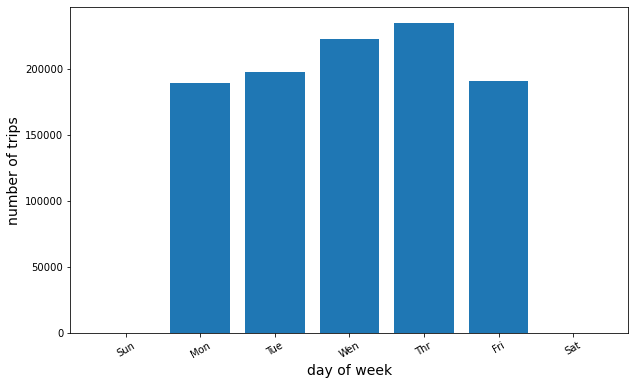

In [18]:
plt.figure(figsize=(10, 6))

plt.bar(tripsByday.pickday, tripsByday.N_trips)
tick=['Sun','Mon','Tue','Wen','Thr','Fri','Sat']
plt.xticks(range(0,7),tick,rotation=30)
plt.ylabel('number of trips', fontsize=14)
plt.xlabel('day of week', fontsize=14)

In [19]:
speed_day = data_yellow[['pickday', 'trip_distance', 'trip_duration']].groupby(by='pickday', as_index=False).sum()
speed_day['speed'] = speed_day['trip_distance'] / speed_day['trip_duration'] * 60
speed_day

,pickday,trip_distance,trip_duration,speed
0,0,1228.75,77675.0,0.949147
1,1,666601.78,3354364.0,11.923604
2,2,634568.20,3259370.0,11.681427
3,3,659369.54,3787890.0,10.444383
4,4,660308.08,3837535.0,10.323941
5,5,499016.78,2960340.0,10.114043
6,6,53.79,2987.0,1.080482


Text(0.5, 0, 'day of week')

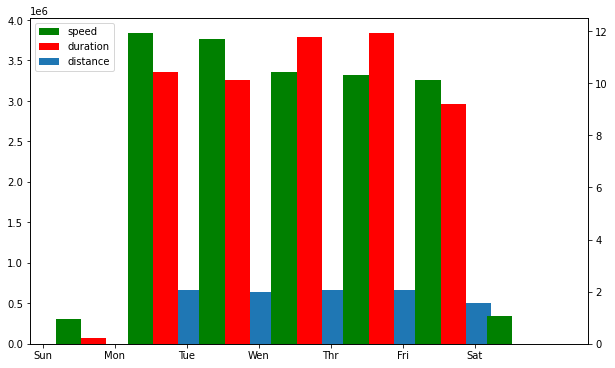

In [63]:
import matplotlib.patches as mpatches
fig=plt.figure(figsize=(10, 6))
ax1=fig.add_subplot(1,1,1)
ax1.bar(speed_day.pickday+0.7,speed_day.trip_duration,0.35,color='r')
ax2=ax1.twinx()
ax2.bar(speed_day.pickday+0.35,speed_day.speed,0.35,color='g')
ax1.bar(speed_day.pickday+1.05,speed_day.trip_distance,0.35)
plt.xticks(range(0,7),tick,rotation=30)
LegendElement = [
                mpatches.Patch(facecolor='g', label='speed'),
                mpatches.Patch(facecolor='r', label='duration'),
                mpatches.Patch(label='distance')
                ]
plt.legend(handles = LegendElement, loc='upper left')

#plt.ylabel('average speed (mph)', fontsize=14)
plt.xlabel('day of week', fontsize=14)


# 4. Identify and visualize on the map the top 10 and bottom 10 areas by largest trip density, average speed and average distance (grouped by origin) 

In [138]:
trips_d = data_yellow.groupby(by='PULocationID', as_index=False).count()[['PULocationID', 'DOLocationID']]
trips_d.rename(columns={'DOLocationID':'N_trips'}, inplace=True)
tripsden = taxi.merge(trips_d, left_on='location_i', right_on='PULocationID')
tripsden=tripsden.sort_values(by=['N_trips'],ascending=False)
index=range(0,len(tripsden))
tripsden.index=index

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,PULocationID,N_trips
0,Manhattan,161.0,161.0,0.000072,0.035804,Midtown Center,"POLYGON ((-73.97534 40.75530, -73.97581 40.754...",161,40302
1,Manhattan,237.0,237.0,0.000096,0.042213,Upper East Side South,"POLYGON ((-73.96613 40.76218, -73.96658 40.761...",237,39965
2,Manhattan,236.0,236.0,0.000103,0.044252,Upper East Side North,"POLYGON ((-73.95779 40.77360, -73.95826 40.772...",236,38605
3,Manhattan,186.0,186.0,0.000037,0.024696,Penn Station/Madison Sq West,"POLYGON ((-73.99097 40.74542, -73.99142 40.744...",186,37066
4,Manhattan,230.0,230.0,0.000056,0.031028,Times Sq/Theatre District,"POLYGON ((-73.98362 40.75552, -73.98412 40.754...",230,35379
...,...,...,...,...,...,...,...,...,...
246,Staten Island,109.0,109.0,0.001170,0.178268,Great Kills,"POLYGON ((-74.14706 40.57051, -74.14699 40.570...",109,2
247,Staten Island,245.0,245.0,0.000466,0.095983,West Brighton,"POLYGON ((-74.09788 40.64036, -74.09767 40.638...",245,2
248,Queens,30.0,30.0,0.000146,0.094510,Broad Channel,"POLYGON ((-73.82076 40.61523, -73.81769 40.614...",30,1
249,Staten Island,187.0,187.0,0.000421,0.126868,Port Richmond,"MULTIPOLYGON (((-74.13435 40.64189, -74.13430 ...",187,1


(-74.28337047811293, -73.67222994897456, 40.47514452607875, 40.936503646094195)

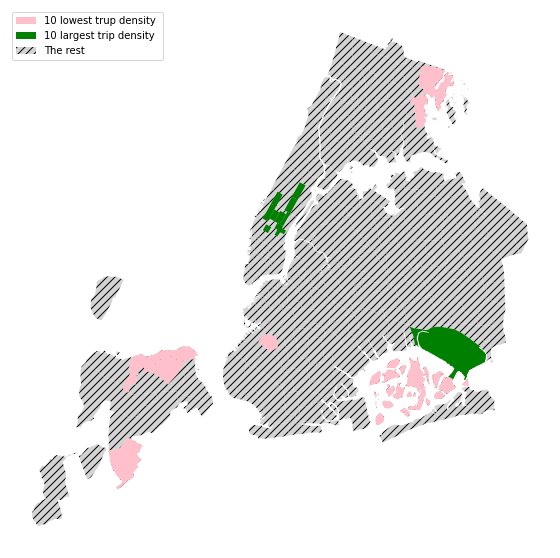

In [174]:
fig,ax= plt.subplots(figsize=(10,10))
tripsden.plot(facecolor='lightgrey',hatch='///',ax=ax)
tripsden.loc[tripsden['N_trips']>tripsden['N_trips'][10]].plot(facecolor='g',ax=ax)
tripsden.loc[tripsden['N_trips']<tripsden['N_trips'][len(tripsden)-11]].plot(facecolor='pink',ax=ax)
LegendElement = [
                mpatches.Patch(facecolor='pink', label='10 lowest trup density '),
                mpatches.Patch(facecolor='g', label='10 largest trip density '),
                mpatches.Patch(facecolor='lightgrey',hatch='///', label='The rest ')
                ]
ax.legend(handles = LegendElement, loc='upper left')
ax.axis('off')

In [161]:
speed_visiz=speed_visiz.sort_values(by=['speed'],ascending=False)
index=range(0,len(speed_visiz))
speed_visiz.index=index

(-74.28337047811293,
 -73.67222994897456,
 40.475350296182725,
 40.932182473910764)

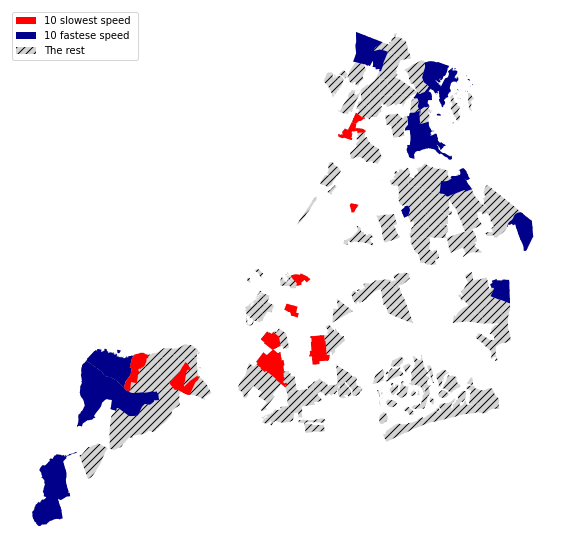

In [173]:
fig,ax= plt.subplots(figsize=(10,10))
speed_visiz.plot(facecolor='lightgrey',hatch='///',ax=ax)
speed_visiz.loc[speed_visiz['speed']>speed_visiz['speed'][10]].plot(facecolor='darkblue',ax=ax)
speed_visiz.loc[speed_visiz['speed']<speed_visiz['speed'][len(speed_visiz)-11]].plot(facecolor='r',ax=ax)
LegendElement = [
                mpatches.Patch(facecolor='r', label='10 slowest speed '),
                mpatches.Patch(facecolor='darkblue', label='10 fastese speed '),
                mpatches.Patch(facecolor='lightgrey',hatch='///', label='The rest ')
                ]
ax.legend(handles = LegendElement, loc='upper left')
ax.axis('off')

In [168]:
distance_visiz=distance_visiz.sort_values(by=['trip_distance'],ascending=False)
index=range(0,len(distance_visiz))
distance_visiz.index=index

(-74.28337047811293, -73.67222994897456, 40.47514452607875, 40.936503646094195)

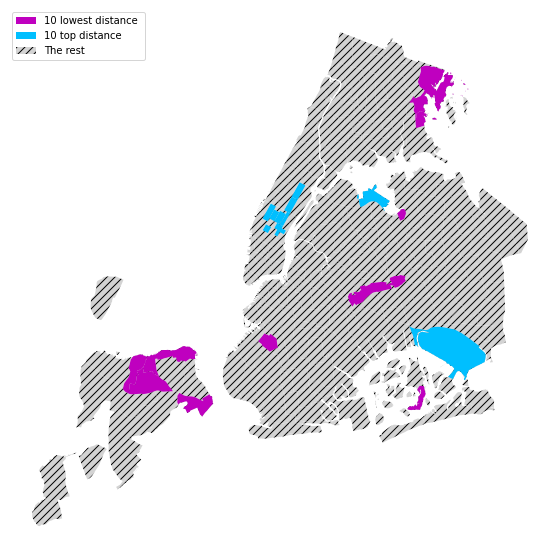

In [172]:
fig,ax= plt.subplots(figsize=(10,10))
distance_visiz.plot(facecolor='lightgrey',hatch='///',ax=ax)
distance_visiz.loc[distance_visiz['trip_distance']>distance_visiz['trip_distance'][10]].plot(facecolor='deepskyblue',ax=ax)
distance_visiz.loc[distance_visiz['trip_distance']<distance_visiz['trip_distance'][len(distance_visiz)-11]].plot(facecolor='m',ax=ax)
LegendElement = [
                mpatches.Patch(facecolor='m', label='10 lowest distance '),
                mpatches.Patch(facecolor='deepskyblue', label='10 top distance'),
                mpatches.Patch(facecolor='lightgrey',hatch='///', label='The rest ')
                ]
ax.legend(handles = LegendElement, loc='upper left')
ax.axis('off')